# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [103]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [23]:
# create a Spark session
spark = SparkSession \
.builder \
.appName("Sparkify") \
.getOrCreate()

In [24]:
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist

<bound method DataFrame.persist of DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]>

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [25]:
df.count()

286500

In [26]:
df_valid = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [28]:
df_valid.select("userID").dropDuplicates().sort("userID").show()

+------+
|userID|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [29]:
df_valid.select("sessionID").dropDuplicates().sort("userID").show()

+---------+
|sessionID|
+---------+
|     1338|
|       22|
|      330|
|      241|
|     2263|
|      155|
|      299|
|      237|
|      564|
|      347|
|       54|
|      926|
|      270|
|     1217|
|     2088|
|     1532|
|     1277|
|     1409|
|      656|
|      293|
+---------+
only showing top 20 rows



In [30]:
df_valid = df_valid.filter(df["userId"] != "")
df_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [33]:
df_valid.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [38]:
churn_user_df = df.filter(df.page =="Cancellation Confirmation").select("userID").dropDuplicates()
churn_user_list = [user["userID"] for user in churn_user_df.collect()]

In [43]:
df_valid = df_valid.withColumn("churn" , df_valid.userId.isin(churn_user_list))

In [47]:
df_valid.dropDuplicates(["userID"]).groupby(['gender', 'churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     M| true|   32|
|     F|false|   84|
|     F| true|   20|
|     M|false|   89|
+------+-----+-----+



In [48]:
churn_rate_of_females = 20/(20+84)
churn_rate_of_males=  32/ (32+89)

print("Churn rate of females: ", churn_rate_of_females)
print("Churn rate of males: ", churn_rate_of_males)

Churn rate of females:  0.19230769230769232
Churn rate of males:  0.2644628099173554


In [54]:
df_valid_songs = df_valid.where(df_valid.song!='null').groupby(['churn','userId']) \
    .agg(count(df_valid.song).alias('SongsPlayed')).orderBy('churn').toPandas()

[]

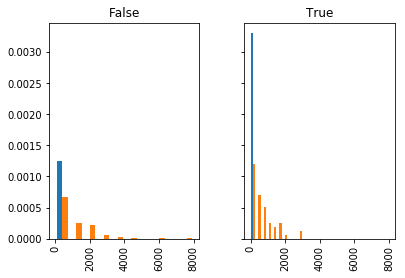

In [60]:
df_valid_songs.hist(['SongsPlayed'], by='churn', sharex=True, sharey=True,density=1)
plt.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1849e9668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe1849ae550>], dtype=object)

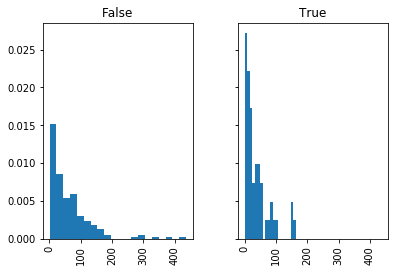

In [65]:
df_valid_thumbsup = df_valid.where(df_valid.page =='Thumbs Up').groupby(['churn', 'userId']) \
.agg(count(col('page')).alias('ThumbsUp')).orderBy('churn').toPandas()
df_valid_thumbsup.hist('ThumbsUp', by = 'churn', bins = 20, sharex = True, sharey = True, density =1 )

In [69]:
print('ThumbsUps for people who stay',df_valid_thumbsup[df_valid_thumbsup['churn']==False]['ThumbsUp'].mean())
print('ThumbsUps for people who leave',df_valid_thumbsup[df_valid_thumbsup['churn']==True]['ThumbsUp'].mean())

ThumbsUps for people who stay 62.8941176471
ThumbsUps for people who leave 37.18


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1849be048>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fe184ab3f28>], dtype=object)

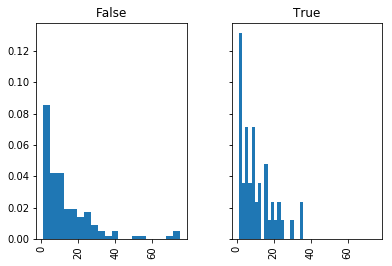

In [70]:
df_valid_thumbsdown = df_valid.where(df_valid.page=='Thumbs Down') \
    .groupby(['churn','userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('churn').toPandas()
df_valid_thumbsdown.hist('ThumbsDowns', by='churn', bins=20, sharex=True, sharey=True, density=1)

In [71]:
print('ThumbsDowns for people who stay',df_valid_thumbsdown[df_valid_thumbsup['churn']==False]['ThumbsDowns'].mean())
print('ThumbsDowns for people who leave',df_valid_thumbsdown[df_valid_thumbsup['churn']==True]['ThumbsDowns'].mean())

ThumbsDowns for people who stay 12.7352941176
ThumbsDowns for people who leave 11.5454545455


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [78]:
df_gender = df_valid.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
df_gender = df_gender.replace(['F','M'],['1', '0'], 'gender')
df_gender.withColumn('gender', df_gender.gender.cast("int"))

DataFrame[userId: string, gender: int]

In [81]:
df_gender.show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



In [82]:
df_songs = df_valid.where(df_valid.song!='null').groupby('userId') \
    .agg(count(df_valid.song).alias('SongsPlayed')).orderBy('userId') \
    .select(['userId','SongsPlayed'])

In [83]:
df_songs.show()

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
|100004|        942|
|100005|        154|
|100006|         26|
|100007|        423|
|100008|        772|
|100009|        518|
|100010|        275|
|100011|         11|
|100012|        476|
|100013|       1131|
|100014|        257|
|100015|        800|
|100016|        530|
|100017|         52|
|100018|       1002|
+------+-----------+
only showing top 20 rows



In [84]:
df_thumbsup = df_valid.where(df_valid.page=='Thumbs Up') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps')).orderBy('userId').select(['userId','ThumbsUps'])

In [85]:
df_thumbsdown = df_valid.where(df_valid.page=='Thumbs Down') \
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns')).orderBy('userId').select(['userId','ThumbsDowns'])

In [87]:
df_singers = df_valid.dropDuplicates(['userId','artist']).groupby('userId') \
    .agg(count(df_valid.artist).alias('SingersListened')).orderBy('userId') \
    .select(['userId','SingersListened'])

In [88]:
df_singers.show()

+------+---------------+
|userId|SingersListened|
+------+---------------+
|    10|            565|
|   100|           1705|
|100001|            125|
|100002|            184|
|100003|             50|
|100004|            733|
|100005|            149|
|100006|             26|
|100007|            357|
|100008|            623|
|100009|            442|
|100010|            252|
|100011|             11|
|100012|            397|
|100013|            826|
|100014|            233|
|100015|            627|
|100016|            431|
|100017|             51|
|100018|            780|
+------+---------------+
only showing top 20 rows



In [89]:
df_final = df_valid.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])

for feature in [df_gender, df_songs, df_thumbsup, df_thumbsdown, df_singers]:
    df_final = df_final.join(feature, 'userId')

In [91]:
df_final.show()

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010|false|     1|        275|       17|          5|            252|
|200002|false|     0|        387|       21|          6|            339|
|   124|false|     1|       4079|      171|         41|           2232|
|    51| true|     0|       2111|      100|         21|           1385|
|     7|false|     0|        150|        7|          1|            142|
|    15|false|     0|       1914|       81|         14|           1302|
|    54| true|     1|       2841|      163|         29|           1744|
|   155|false|     1|        820|       58|          3|            643|
|100014| true|     0|        257|       17|          3|            233|
|   132|false|     1|       1928|       96|         17|           1299|
|   101| true|     0|       1797|       86|         16|         

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [92]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
| true|   47|
|false|  155|
+-----+-----+



In [93]:
df_final.dtypes

[('userId', 'string'),
 ('churn', 'boolean'),
 ('gender', 'string'),
 ('SongsPlayed', 'bigint'),
 ('ThumbsUps', 'bigint'),
 ('ThumbsDowns', 'bigint'),
 ('SingersListened', 'bigint')]

In [96]:
for feature in df_final.columns[1:]:
    df_final = df_final.withColumn(feature,df_final[feature].cast('float'))

In [97]:
df_final.dtypes

[('userId', 'string'),
 ('churn', 'float'),
 ('gender', 'float'),
 ('SongsPlayed', 'float'),
 ('ThumbsUps', 'float'),
 ('ThumbsDowns', 'float'),
 ('SingersListened', 'float')]

In [98]:
df_final.show(5)

+------+-----+------+-----------+---------+-----------+---------------+
|userId|churn|gender|SongsPlayed|ThumbsUps|ThumbsDowns|SingersListened|
+------+-----+------+-----------+---------+-----------+---------------+
|100010|  0.0|   1.0|      275.0|     17.0|        5.0|          252.0|
|200002|  0.0|   0.0|      387.0|     21.0|        6.0|          339.0|
|   124|  0.0|   1.0|     4079.0|    171.0|       41.0|         2232.0|
|    51|  1.0|   0.0|     2111.0|    100.0|       21.0|         1385.0|
|     7|  0.0|   0.0|      150.0|      7.0|        1.0|          142.0|
+------+-----+------+-----------+---------+-----------+---------------+
only showing top 5 rows



In [99]:
train, test = df_final. randomSplit ([0.8, 0.2], seed = 40)

In [100]:
assembler = VectorAssembler(inputCols=df_final.columns[2:],outputCol='featuresassemble')
scaler = StandardScaler(inputCol="featuresassemble", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")
rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="indexed", seed=42)

In [104]:
pipeline_lr = Pipeline(stages=[assembler, scaler, indexer, lr])

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, 0.01]) \
    .build()


crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [105]:
cvModel_lr = crossval_lr.fit(train)

In [106]:
cvModel_lr.avgMetrics

[0.6025505998672367, 0.570234476316766, 0.5864861634092403]

In [107]:
# test performance
results = cvModel_lr.transform(test)
BinaryClassificationEvaluator().evaluate(results)

0.7225806451612905

In [108]:
train_2, test_2 = df_final.randomSplit([0.9, 0.1], seed=43)
cvModel_lr_2 = crossval_lr.fit(train_2)
print(cvModel_lr_2.avgMetrics)
results_2 = cvModel_lr.transform(test_2)
print(BinaryClassificationEvaluator().evaluate(results_2))

[0.669031746031746, 0.649031746031746, 0.6603809523809523]
0.37254901960784315


In [109]:
train_3, test_3 = df_final.randomSplit([0.9, 0.1], seed=44)
cvModel_lr_3 = crossval_lr.fit(train_3)
print(cvModel_lr_3.avgMetrics)
results_3 = cvModel_lr.transform(test_3)
print(BinaryClassificationEvaluator().evaluate(results_3))

[0.6304115866296305, 0.6076304185243654, 0.6262565373978866]
0.8409090909090908


In [110]:
pipeline_rf = Pipeline(stages=[assembler, scaler, indexer, stringIndexer, rf])

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[10, 30]) \
    .build()


crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

In [111]:
cvModel_rf = crossval_rf.fit(train)

In [112]:
cvModel_rf.avgMetrics

[0.5560187675572291, 0.5999204532299344]

In [113]:
results = cvModel_rf.transform(test)

In [114]:
print(BinaryClassificationEvaluator().evaluate(results))


0.5951612903225806


In [115]:
train_2, test_2 = df_final.randomSplit([0.9, 0.1], seed=43)
cvModel_rf_2 = crossval_rf.fit(train_2)
print(cvModel_rf_2.avgMetrics)
results_2 = cvModel_rf_2.transform(test_2)
print(BinaryClassificationEvaluator().evaluate(results_2))

[0.5988174603174603, 0.6608869047619048]
0.3137254901960784


In [116]:
train_3, test_3 = df_final.randomSplit([0.9, 0.1], seed=44)
cvModel_rf_3 = crossval_rf.fit(train_3)
print(cvModel_rf_3.avgMetrics)
results_3 = cvModel_rf_3.transform(test_3)
print(BinaryClassificationEvaluator().evaluate(results_3))

[0.5422493273886974, 0.5355126550409415]
0.6931818181818181


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.